In [1]:
import numpy
import pystore

from datetime import *
import os
import os.path

import pandas as pd
from dataclasses import make_dataclass


storepath = "../store"
print("using store at " + storepath) 
if not os.path.exists(storepath):
    os.mkdir(storepath)

pystore.set_path(storepath)
store = pystore.store('serre_store')

# Access a collection (create it if not exist)
collection = store.collection('serre')
SerreData = make_dataclass("SerreData", [("TIME", datetime), ("TEMPERATURE", float), ("LIGHT", float), 
          ("HUMIDITY", float), ("SOIL", float), ("LIGHTCMD", int)])

# read collection
readdf = collection.item("serre")
print(readdf.data.loc[(datetime.now() - timedelta(hours=3)):].compute().agg( {'SOIL':['mean','std'], 'LIGHT': ['min','max','mean'], 'HUMIDITY':['min','max','mean','std']}))
print(readdf.data.loc[(datetime.now() - timedelta(days=5)):].compute().agg( {'SOIL':['mean','std','min','max'],  'LIGHT':['min','max','mean'], 'HUMIDITY':['min','max','mean','std']}))



using store at ../store
            SOIL        LIGHT   HUMIDITY
mean  524.734739   716.792453  91.517259
std    39.745367          NaN  13.609491
min          NaN   336.000000  65.200000
max          NaN  1023.000000  99.900000
            SOIL        LIGHT   HUMIDITY
mean  450.655852   893.582292  99.472395
std    42.801083          NaN   3.248166
min   364.000000   116.000000  65.200000
max   595.000000  1023.000000  99.900000


In [2]:
keymetrics = readdf.data[['LIGHT', 'LIGHTCMD', 'HUMIDITY', 'TEMPERATURE', 'SOIL', 'TIME']].resample('15min').mean().compute()

In [5]:
keymetrics2 = keymetrics.iloc[-1000:][["LIGHT"]] # .dropna()

In [6]:
keymetrics2.index = pd.DatetimeIndex(keymetrics.index).to_period('15m')

ValueError: Length mismatch: Expected axis has 1000 elements, new values have 2499 elements

<AxesSubplot:>

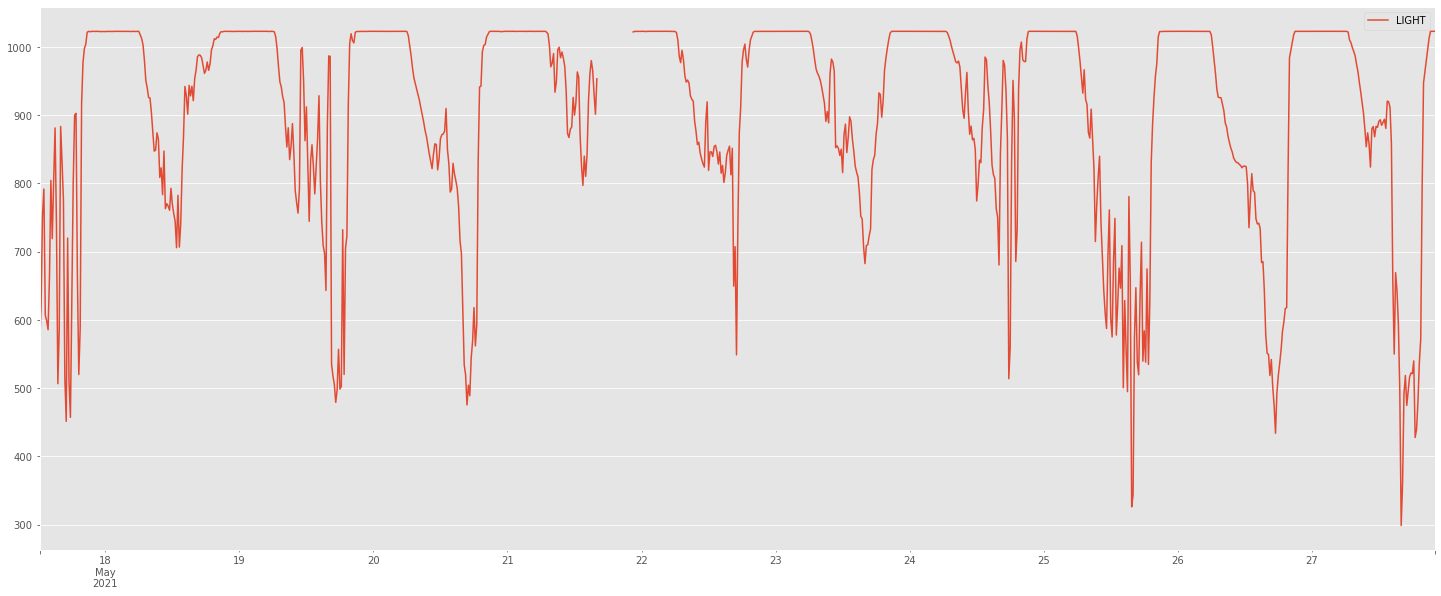

In [7]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use("ggplot")

keymetrics2.plot(figsize=(25,10))

In [8]:
onlylight = keymetrics2[["LIGHT"]]
onlylight

,LIGHT
2021-05-17 12:15:00,562.688889
2021-05-17 12:30:00,622.200000
2021-05-17 12:45:00,752.622222
2021-05-17 13:00:00,791.855556
2021-05-17 13:15:00,607.266667
...,...
2021-05-27 21:00:00,1013.333333
2021-05-27 21:15:00,1022.900000
2021-05-27 21:30:00,1023.000000
2021-05-27 21:45:00,1023.000000


In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(onlylight.dropna(), period=24*4)

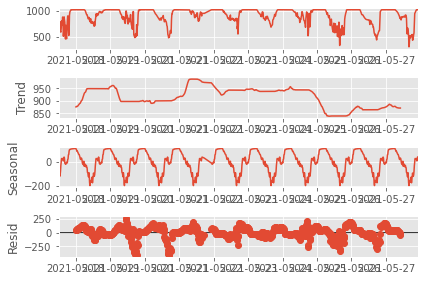

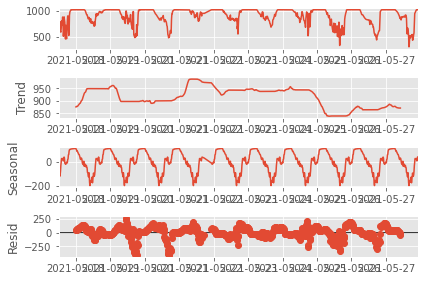

In [11]:
result.plot()

<AxesSubplot:>

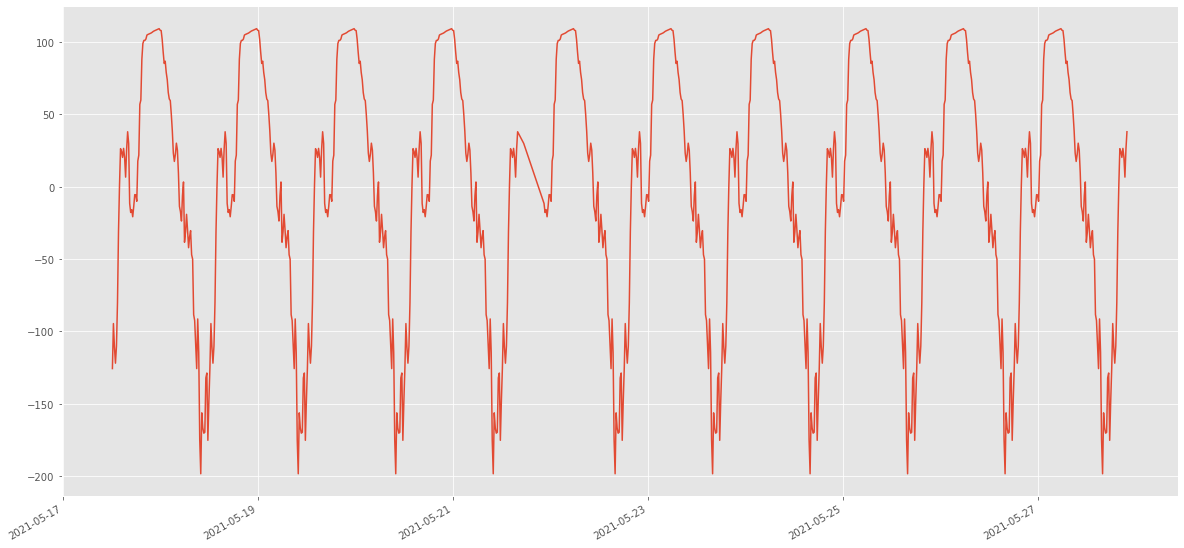

In [12]:
result.seasonal.plot(figsize=(20,10))

<AxesSubplot:>

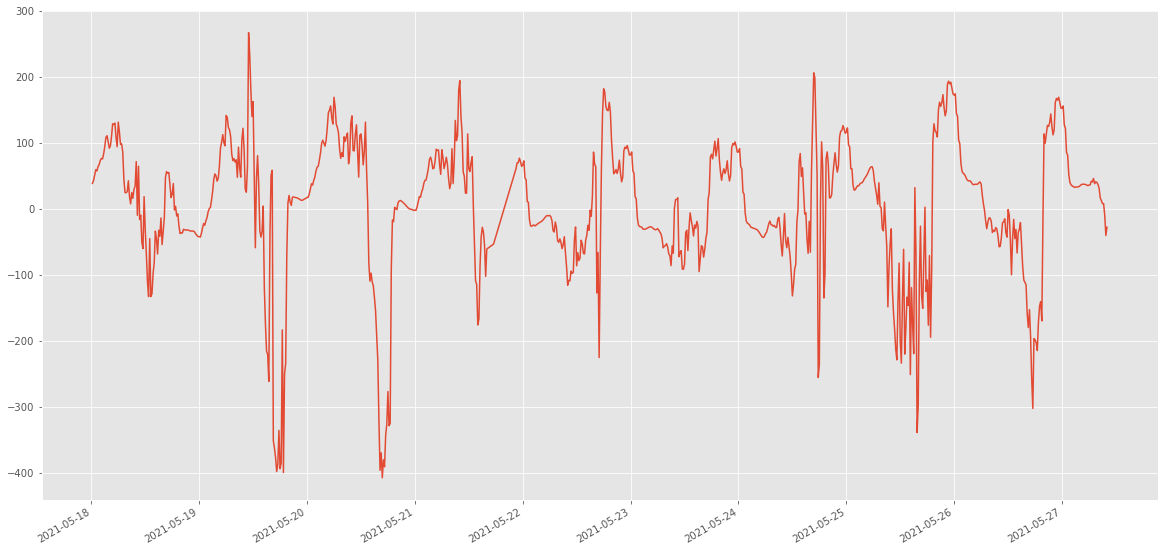

In [13]:
result.resid.plot(figsize=(20,10))

In [14]:
import statsmodels.api as sm


onlylight['ds'] = pd.to_numeric(onlylight.index)
onlylight['y'] = onlylight['LIGHT']
onlylight

,LIGHT,ds,y
2021-05-17 12:15:00,562.688889,1621253700000000000,562.688889
2021-05-17 12:30:00,622.200000,1621254600000000000,622.200000
2021-05-17 12:45:00,752.622222,1621255500000000000,752.622222
2021-05-17 13:00:00,791.855556,1621256400000000000,791.855556
2021-05-17 13:15:00,607.266667,1621257300000000000,607.266667
...,...,...,...
2021-05-27 21:00:00,1013.333333,1622149200000000000,1013.333333
2021-05-27 21:15:00,1022.900000,1622150100000000000,1022.900000
2021-05-27 21:30:00,1023.000000,1622151000000000000,1023.000000
2021-05-27 21:45:00,1023.000000,1622151900000000000,1023.000000


In [15]:
import statsmodels.api as sm
import numpy as np
np.asarray(onlylight)

array([[5.62688889e+02, 1.62125370e+18, 5.62688889e+02],
       [6.22200000e+02, 1.62125460e+18, 6.22200000e+02],
       [7.52622222e+02, 1.62125550e+18, 7.52622222e+02],
       ...,
       [1.02300000e+03, 1.62215100e+18, 1.02300000e+03],
       [1.02300000e+03, 1.62215190e+18, 1.02300000e+03],
       [1.02300000e+03, 1.62215280e+18, 1.02300000e+03]])

In [16]:
pd.to_numeric(onlylight.index)

Int64Index([1621253700000000000, 1621254600000000000, 1621255500000000000,
            1621256400000000000, 1621257300000000000, 1621258200000000000,
            1621259100000000000, 1621260000000000000, 1621260900000000000,
            1621261800000000000,
            ...
            1622144700000000000, 1622145600000000000, 1622146500000000000,
            1622147400000000000, 1622148300000000000, 1622149200000000000,
            1622150100000000000, 1622151000000000000, 1622151900000000000,
            1622152800000000000],
           dtype='int64', length=1000)

In [17]:


mod_ar2 = sm.tsa.SARIMAX(onlylight[["y"]], order=(2,0,0))

In [18]:
res_ar2 = mod_ar2.fit()
# Note that res_ar2 is an instance of the SARIMAXResults class

# Show the summary of results
print(res_ar2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -5326.457
Date:                Thu, 27 May 2021   AIC                          10658.915
Time:                        20:03:36   BIC                          10673.638
Sample:                    05-17-2021   HQIC                         10664.511
                         - 05-27-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0699      0.018     60.533      0.000       1.035       1.105
ar.L2         -0.0721      0.018     -4.057      0.000      -0.107      -0.037
sigma2      3184.9901     52.097     61.136      0.0